<a href="https://colab.research.google.com/github/ctran0905/AI4ALL/blob/main/ASL_Translator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!pip install tensorflow keras matplotlib scikit-learn'

/bin/bash: -c: line 1: unexpected EOF while looking for matching `''
/bin/bash: -c: line 2: syntax error: unexpected end of file


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Mounted at /content/drive


This part of the code is to mount the kaggle dataset. Only need to run if the dataset is not already uploaded

In [ ]:
os.getcwd()
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Group C/Dataset"
os.chdir('/content/drive/MyDrive/Group C/Dataset')

!kaggle datasets download -d grassknoted/asl-alphabet
os.listdir()

Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
asl-alphabet.zip: Skipping, found more recently modified local copy (use --force to force download)


['asl_alphabet', 'asl-alphabet.zip', 'kaggle.json']

In [ ]:
!unzip -q asl-alphabet.zip -d asl_alphabet

unzip:  cannot find or open asl-alphabet.zip, asl-alphabet.zip.zip or asl-alphabet.zip.ZIP.


# Copy dataset from Google Drive and move to Colab

> ONLY run if dataset is not in colab folder, double check before running




In [3]:
print("Copying dataset to local storage for faster training...")
!cp -r "/content/drive/MyDrive/Group C/Dataset/asl_alphabet" "/content/"
print("Copy complete!")

Copying dataset to local storage for faster training...
Copy complete!


In [ ]:
# Sampling size per class
train_per_class = 300
validation_per_class = 85
test_per_class = 40

# Data Visualization - Preprocessing


Updated TRAIN_DIR: /content/asl_alphabet/asl_alphabet_train/asl_alphabet_train
Updated TEST_DIR: /content/asl_alphabet/asl_alphabet_test
Train dir exists: True
Test dir exists: True


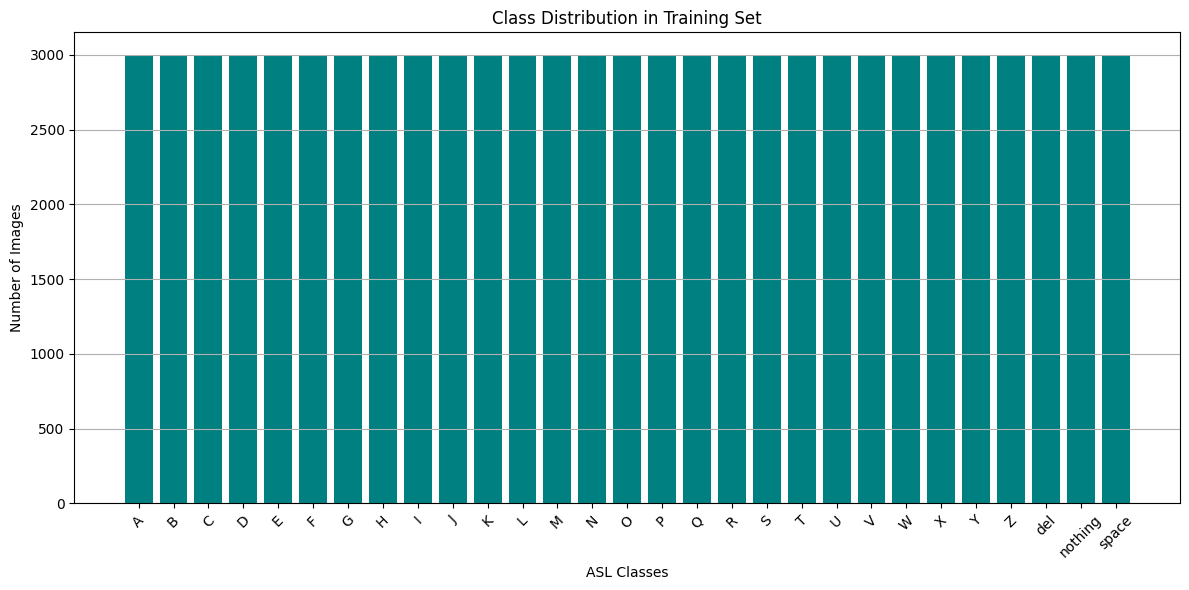

In [ ]:
import cv2

# Define path to the image directories

# Google Drive Paths:
'''
  TRAIN_DIR = '/content/drive/MyDrive/Group C/Dataset/asl_alphabet/asl_alphabet_train/asl_alphabet_train'
  TEST_DIR = '/content/drive/MyDrive/Group C/Dataset/asl_alphabet/asl_alphabet_test'
'''

# Local Colab path to image directories, check colab folder for 'content' file

TRAIN_DIR = '/content/asl_alphabet/asl_alphabet_train/asl_alphabet_train'
TEST_DIR = '/content/asl_alphabet/asl_alphabet_test'

# Checking if the folder paths exist

print(f"Updated TRAIN_DIR: {TRAIN_DIR}")
print(f"Updated TEST_DIR: {TEST_DIR}")
print(f"Train dir exists: {os.path.exists(TRAIN_DIR)}")
print(f"Test dir exists: {os.path.exists(TEST_DIR)}")


#number of images in each alphabet directory
category_counts = {
    cat: len(os.listdir(os.path.join(TRAIN_DIR, cat)))
    for cat in sorted(os.listdir(TRAIN_DIR))
    if os.path.isdir(os.path.join(TRAIN_DIR, cat))
}

plt.figure(figsize=(12, 6))
plt.bar(category_counts.keys(), category_counts.values(), color='teal')
plt.title("Class Distribution in Training Set")
plt.xlabel("ASL Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

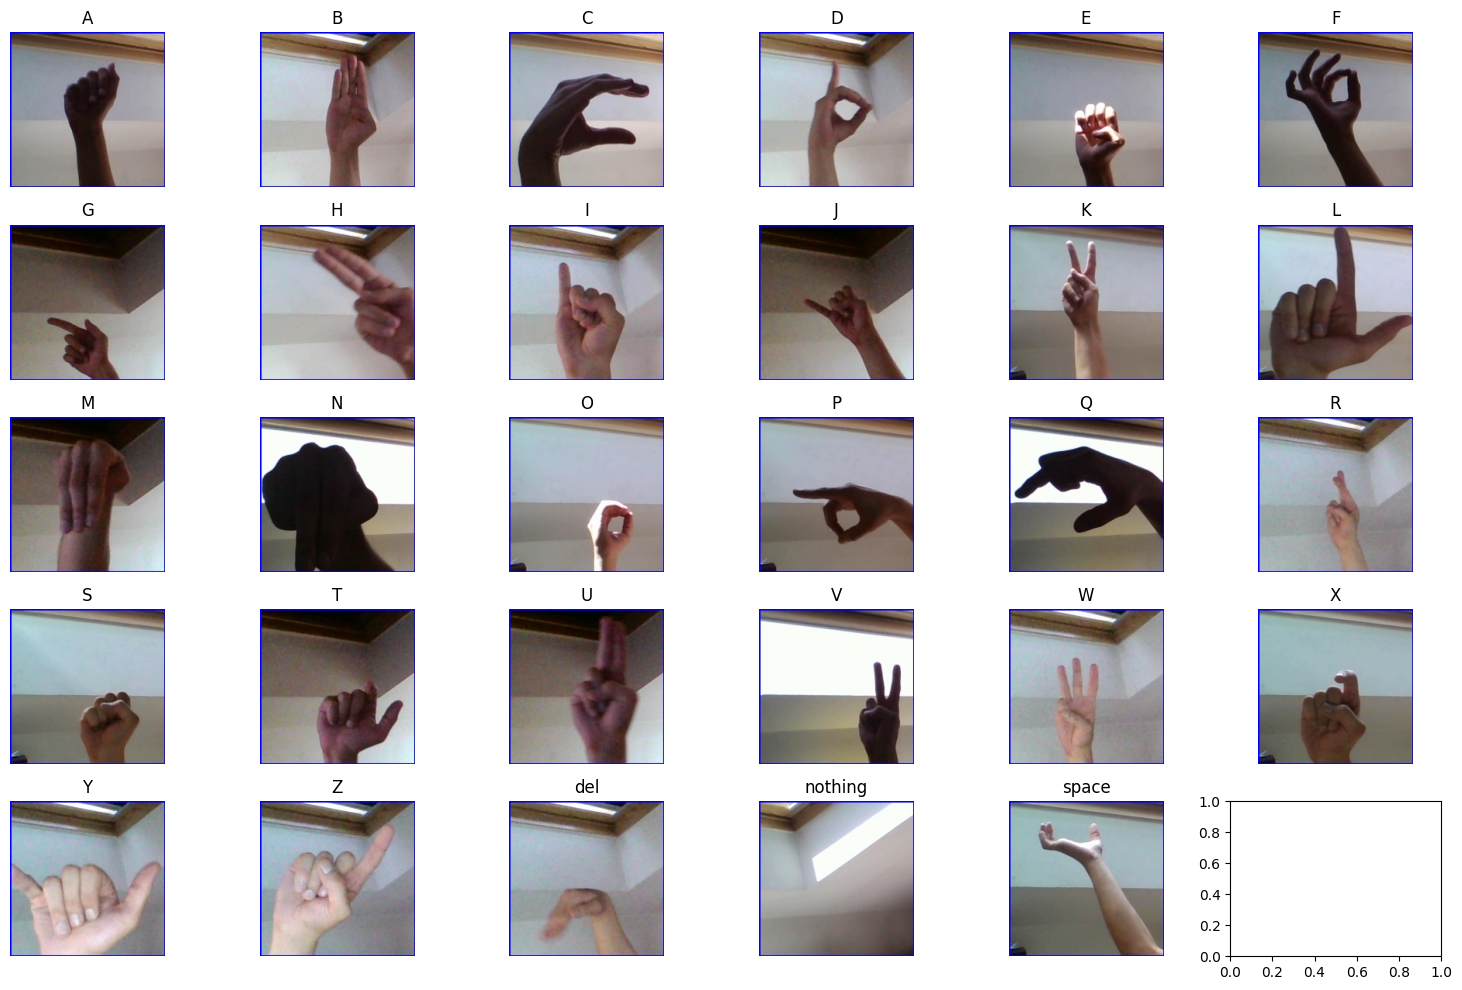

In [ ]:
#Show one picture from each category
fig, axs = plt.subplots(5, 6, figsize=(15, 10))
axs = axs.ravel()

for i, cat in enumerate(sorted(category_counts.keys())):
    class_path = os.path.join(TRAIN_DIR, cat)
    sample_img_path = os.path.join(class_path, os.listdir(class_path)[0])
    img = cv2.imread(sample_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].imshow(img)
    axs[i].set_title(cat)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

##Image Issues
* Skin tone - light skin dataset. Limitation of our dataset which can cause problems
* Resolution - there are many different lighting situations but they could be favorable for testing under a broad spectrum

Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Number of classes: 29


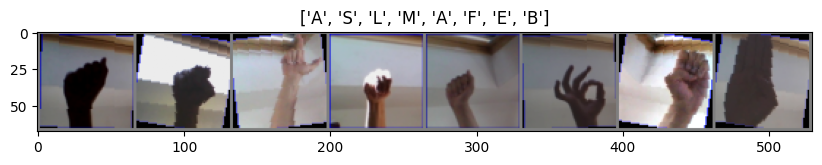

In [ ]:
from torchvision import datasets, transforms, utils
from PIL import Image
from torch.utils.data import random_split, DataLoader
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_generator = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=10,
#     zoom_range=0.1,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     validation_split=0.2 #80/20 split
# );

#Using transform from slides
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.CenterCrop(64),    # Ensure square and centered
    transforms.ColorJitter(brightness=0.4, contrast=0.4),  # Reduce lighting variance
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transform)

# View class labels
class_names = train_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)
print("Number of classes:", num_classes)


# Split into 80% train, 20% validation
val_split = 0.2
val_size = int(len(train_dataset) * val_split)
train_size = len(train_dataset) - val_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


# Optimized DataLoader settings for A100

#Increase Batch Size from 32 to 256 - model training purposes
batch_size = 256
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          #Added num workers, Number of parallel data loading processes (currently single threading)
                          num_workers=0,
                          #Added Pin memory, helps with GPU transfer speed
                          pin_memory=True,
                          )

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        #Added num workers, Number of parallel data loading processes (currently single threading)
                        num_workers=0,
                        #Added Pin memory, helps with GPU transfer speed
                        pin_memory=True,
                       )

test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         #Added num workers, Number of parallel data loading processes (currently single threading)
                         num_workers=0,
                         #Added Pin memory, helps with GPU transfer speed
                         pin_memory=True,
                         )


def imshow(img, title):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(10,4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# Get a batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(utils.make_grid(images[:8]), title=[class_names[i] for i in labels[:8]])


##Training with ResNet-18
After setup and preprocessing, we will train our model. Training data has been divided into two splits. Train and validate with an 80/20 split.

Since we want our model to be accurate, we will be training for multiple epochs. We will use the CrossEntropyLoss to understand how wrong the model is after predictions. We then use an optimizer to control the learning rate.

Validation is done during each epoch to monitor performance on unseen data.

 https://www.geeksforgeeks.org/machine-learning/what-is-cross-entropy-loss-function/

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

num_classes = 29

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

#Extra validation step with validation split
def validate_epoch(model, val_loader, loss_fn, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

num_epochs = 5

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer, device)
    val_loss, val_acc = validate_epoch(model, val_loader, loss_fn, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

    save_path = f"/content/drive/MyDrive/Group C/backup/asl_model_epoch{epoch+1}.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

# Model Testing

In [4]:
# Testing model to see final performance
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

# Run test
test_accuracy = test_model(model, test_loader, device)

NameError: name 'model' is not defined

# Model Diagnosis Debuggin

  
> Missing 'del' test class, reason for bad model performance





In [ ]:
# === DIAGNOSE THE PROBLEM ===
print("=== DIAGNOSIS ===")
print("Training classes:", train_dataset.dataset.classes)
print("Test classes:", test_dataset.classes)
print("Classes match?", train_dataset.dataset.classes == test_dataset.classes)

print(f"\nTrain set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Check a few test predictions vs actual
model.eval()
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

print(f"\nSample test batch:")
for i in range(min(8, len(labels))):
    actual = test_dataset.classes[labels[i]]
    predicted = test_dataset.classes[preds[i]]
    print(f"Actual: {actual}, Predicted: {predicted}")